# 1. Подготовка

In [1]:
import pandas as pd

data = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=[0]).sort_index()
data.info()
data.index.is_monotonic

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


True

In [2]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


# 2. Анализ

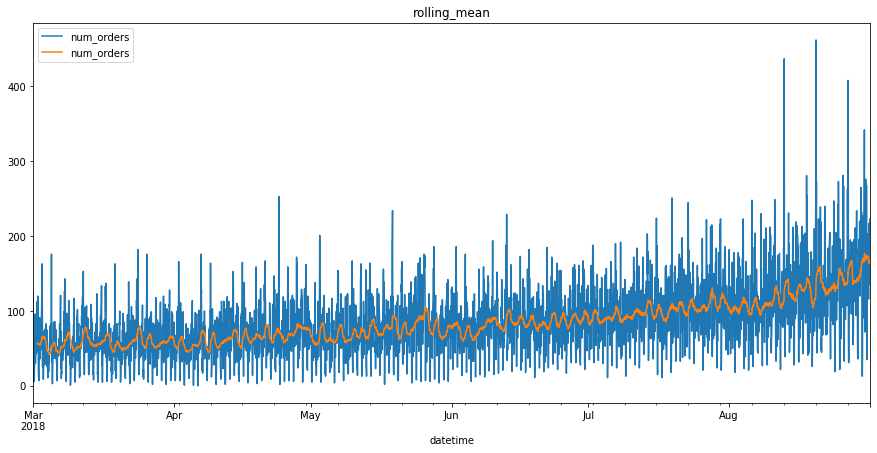

In [4]:
#По заданию горизонт прогнозирования 1 час
data = data.resample('1H').sum()

ax = data.plot(figsize=(15, 7))
data.rolling(24).mean().plot(title='rolling_mean', ax=ax)

По скользящему среднему хорошо видно потепенное увеличение среднего кол-ва заказов за день (я считаю что окно в 24 тут должно имитировать день). Это, как говорится, тренд, так сказать, время отпусков, август - бархатный сезон. Судя по графику пиковая нагрузка еще впереди.

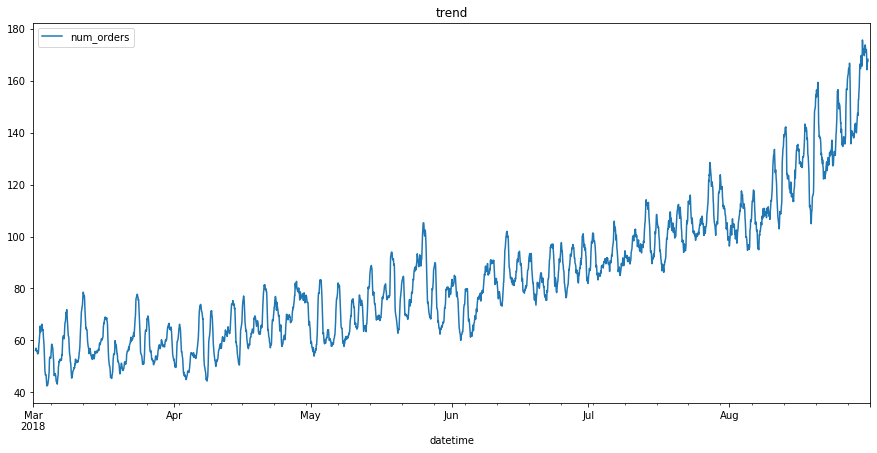

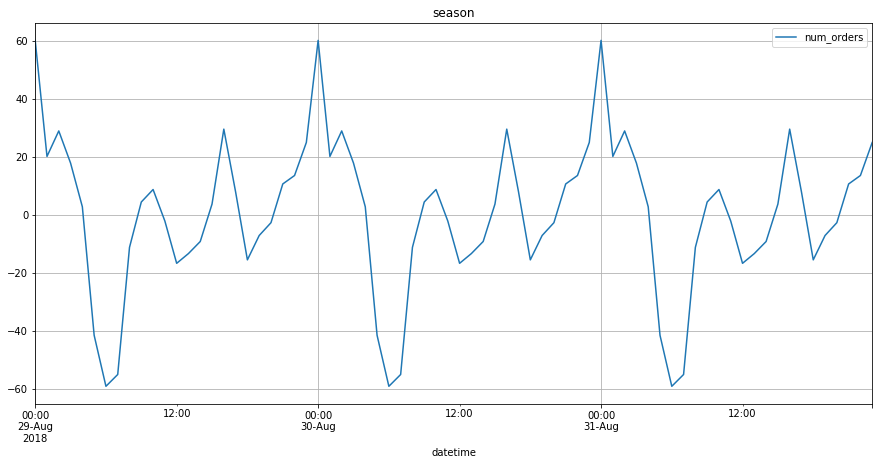

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

time_feat = seasonal_decompose(data)

time_feat.trend.plot(figsize=(15, 7), title='trend')
time_feat.seasonal['2018-08-29':'2018-08-31'].plot(figsize=(15, 7), title='season', grid=True)
#time_feat.resid.plot(figsize=(15, 7), title='residuals')

Тренд уже был выше, а сезонность связанна с периодом в 1 день (получился стационарный ряд) и, скорее всего, с расписанием прилетов и вылетов самолетов. Вообще эти данные должны неплохо коррелировать с данными об авиа рейсах.

-----
Но поскольку таких нет, соберем свои признаки.
1. Первым делом тренд.
1. Если тренд увеличивается в рамках месяца, то признаком и будет месяц.
2. Сезонность развивается в рамках часов, не дней, да и задание на прогноз в часах, поэтому нужен час.
3. Но день надо добавить, для большей дифференциации и точности. Только по часам и месяцам запутаться можно. В дне недели смысла нет, никакой зависимости от него нет.
4. Отстающие значения тоже нужны.

# 3. Обучение

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

def make_features(data, rolling_size, lag):
    d = data.copy()
    
    d['rolling'] = d['num_orders'].shift().rolling(rolling_size).mean()
    d['month'] = d.index.month
    d['hour'] = d.index.hour
    d['day'] = d.index.day
    
    for l in range(1, lag+1):
        d['lag_{}'.format(l)] = d['num_orders'].shift(l)
        
    d = d.dropna()
    X = d.drop('num_orders', axis=1)
    y = d['num_orders']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.1)
    
    return X_train, X_test, y_train, y_test



def rmse_foo(y, pred):
    return mean_squared_error(y, pred)**0.5

rmse = make_scorer(rmse_foo)

In [7]:
X_train, X_test, y_train, y_test = make_features(data, 24, 30)

for n in [X_train, y_train, X_test, y_test]:
    print(n.shape)

(3947, 34)
(3947,)
(439, 34)
(439,)


In [12]:
X_train['lag_1'].to_frame().join(y_train)

,lag_1,num_orders
datetime,,
2018-03-02 06:00:00,11.0,11
2018-03-02 07:00:00,11.0,7
2018-03-02 08:00:00,7.0,46
2018-03-02 09:00:00,46.0,45
2018-03-02 10:00:00,45.0,54
...,...,...
2018-08-13 12:00:00,144.0,92
2018-08-13 13:00:00,92.0,119
2018-08-13 14:00:00,119.0,102


In [13]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

all_in = {LinearRegression(): {},
          SGDRegressor(random_state=42,shuffle=False,): {},
          DecisionTreeRegressor(random_state=42): {'max_depth': [None, 3, 9]},
          RandomForestRegressor(n_estimators=100, random_state=42): {}
         }

for k, v in all_in.items():
    grid_search = GridSearchCV(k, v, cv=5, scoring=rmse, iid=False)
    grid_search.fit(X_train, y_train)
    print(str(k).split('(')[0], 'score:', grid_search.best_score_, 'params:', grid_search.best_params_)

LinearRegression score: 25.50245613398773 params: {}
SGDRegressor score: 84708383432536.95 params: {}
DecisionTreeRegressor score: 34.972657835837495 params: {'max_depth': None}
RandomForestRegressor score: 23.9390111884207 params: {}


Удивлен, что SGDRegressor здесь работает настолько ужасно... Надо проверить на адекватность.

In [14]:
import numpy as np

pred = np.ones(y_test.shape) * y_train.mean()
print(rmse_foo(y_test, pred))

pred = y_test.shift()
pred.iloc[0] = y_train.iloc[-1]
print(rmse_foo(y_test, pred))

84.69779992674266
58.930231711467066


Вроде не все так плохо.

# 4. Тестирование

In [10]:
for model, v in all_in.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(str(model).split('(')[0], 'score:', rmse_foo(y_test, pred))

LinearRegression score: 46.85299086948781
SGDRegressor score: 27337872535098.22
DecisionTreeRegressor score: 61.74735430039048
RandomForestRegressor score: 43.23876355808397


1. Основной вывод напрашивается, что стохастический градиентный спуск для времянных рядов не подходит.
2. Параметры моделей в данном случае, мало влияют на результат, гораздо больше влияет работа по созданию временных признаков. Хотя я думал, они должны переобучать модели, но больше всего вносят в результат "отстающие признаки". 
3. Зато они отрицательно сказываются на Решающем Дереве.
4. Случайный лес универсальная штука. Но его скорость удручает.